# **A Comparative Study of Sentiment Analysis Techniques in Artificial Intelligence**

**Done by:**

- Amna Bubshait (A00723)
- Athbi Salmeen (A01195)
- Zahra Alshehabi (A00755)

**Professor:** Dr. Bara Alalawsh

**Dataset:** [Click here](https://www.kaggle.com/datasets/jp797498e/twitter-entity-sentiment-analysis)

*Artifical Intelligence (COSC 442) Final Project, American University of Bahrain (AUBH), Spring 2025.*

# **1. Load & Explore the Dataset**

In [ ]:
!pip install deap

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 135.6/135.6 kB 5.4 MB/s eta 0:00:00


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import random
import re
import tensorflow as tf

from deap import base, creator, tools, algorithms

from scipy.sparse import hstack, csr_matrix

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score, roc_auc_score, precision_score, recall_score, f1_score
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import LabelEncoder

from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Input, Embedding, LSTM, Dense, Concatenate
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer

In [ ]:
# Install dependencies as needed:
# pip install kagglehub[pandas-datasets]
import kagglehub
from kagglehub import KaggleDatasetAdapter

# Set the path to the file you'd like to load
file_path_train = "twitter_training.csv"

# Load the latest version
train_df = kagglehub.load_dataset(
  KaggleDatasetAdapter.PANDAS,
  "jp797498e/twitter-entity-sentiment-analysis",
  file_path_train,
  # Provide any additional arguments like
  # sql_query or pandas_kwargs. See the
  # documenation for more information:
  # https://github.com/Kaggle/kagglehub/blob/main/README.md#kaggledatasetadapterpandas
)

print("First 5 records:", train_df.head())

<ipython-input-3-d260021bb3e0>:10: DeprecationWarning: load_dataset is deprecated and will be removed in a future version.
  train_df = kagglehub.load_dataset(


100%|██████████| 1.92M/1.92M [00:00<00:00, 82.2MB/s]

Extracting zip of twitter_training.csv...


First 5 records:    2401  Borderlands  Positive  \
0  2401  Borderlands  Positive   
1  2401  Borderlands  Positive   
2  2401  Borderlands  Positive   
3  2401  Borderlands  Positive   
4  2401  Borderlands  Positive   

  im getting on borderlands and i will murder you all ,  
0  I am coming to the borders and I will kill you...     
1  im getting on borderlands and i will kill you ...     
2  im coming on borderlands and i will murder you...     
3  im getting on borderlands 2 and i will murder ...     
4  im getting into borderlands and i can murder y...     


In [ ]:
# Set the path to the file you'd like to load
file_path_valid = "twitter_validation.csv"

# Load the latest version
valid_df = kagglehub.load_dataset(
  KaggleDatasetAdapter.PANDAS,
  "jp797498e/twitter-entity-sentiment-analysis",
  file_path_valid,
  # Provide any additional arguments like
  # sql_query or pandas_kwargs. See the
  # documenation for more information:
  # https://github.com/Kaggle/kagglehub/blob/main/README.md#kaggledatasetadapterpandas
)

print("First 5 records:", valid_df.head())

<ipython-input-4-ce26c0e4e6f0>:5: DeprecationWarning: load_dataset is deprecated and will be removed in a future version.
  valid_df = kagglehub.load_dataset(


First 5 records:    3364   Facebook Irrelevant  \
0   352     Amazon    Neutral   
1  8312  Microsoft   Negative   
2  4371      CS-GO   Negative   
3  4433     Google    Neutral   
4  6273       FIFA   Negative   

  I mentioned on Facebook that I was struggling for motivation to go for a run the other day, which has been translated by Tom’s great auntie as ‘Hayley can’t get out of bed’ and told to his grandma, who now thinks I’m a lazy, terrible person 🤣  
0  BBC News - Amazon boss Jeff Bezos rejects clai...                                                                                                                                                                                                  
1  @Microsoft Why do I pay for WORD when it funct...                                                                                                                                                                                                  
2  CSGO matchmaking is so full of closet ha

In [ ]:
# Assign column names to the datasets
train_df.columns = ['ID', 'Entity', 'Sentiment', 'Tweet_Content']
valid_df.columns = ['ID', 'Entity', 'Sentiment', 'Tweet_Content']

In [ ]:
# Display the first 10 rows of the dataset
print(train_df.head(10))

# Display dataset info (columns, data-types, non-null counts)
print(train_df.info())

     ID       Entity Sentiment  \
0  2401  Borderlands  Positive   
1  2401  Borderlands  Positive   
2  2401  Borderlands  Positive   
3  2401  Borderlands  Positive   
4  2401  Borderlands  Positive   
5  2402  Borderlands  Positive   
6  2402  Borderlands  Positive   
7  2402  Borderlands  Positive   
8  2402  Borderlands  Positive   
9  2402  Borderlands  Positive   

                                       Tweet_Content  
0  I am coming to the borders and I will kill you...  
1  im getting on borderlands and i will kill you ...  
2  im coming on borderlands and i will murder you...  
3  im getting on borderlands 2 and i will murder ...  
4  im getting into borderlands and i can murder y...  
5  So I spent a few hours making something for fu...  
6  So I spent a couple of hours doing something f...  
7  So I spent a few hours doing something for fun...  
8  So I spent a few hours making something for fu...  
9  2010 So I spent a few hours making something f...  
<class 'pandas.core.

In [ ]:
# Display the first 10 rows of the dataset
print(valid_df.head(10))

# Display dataset info (columns, data-types, non-null counts)
print(valid_df.info())

      ID                Entity Sentiment  \
0    352                Amazon   Neutral   
1   8312             Microsoft  Negative   
2   4371                 CS-GO  Negative   
3   4433                Google   Neutral   
4   6273                  FIFA  Negative   
5   7925             MaddenNFL  Positive   
6  11332  TomClancysRainbowSix  Positive   
7   1107        AssassinsCreed  Positive   
8   2069            CallOfDuty  Negative   
9   3185                 Dota2  Positive   

                                       Tweet_Content  
0  BBC News - Amazon boss Jeff Bezos rejects clai...  
1  @Microsoft Why do I pay for WORD when it funct...  
2  CSGO matchmaking is so full of closet hacking,...  
3  Now the President is slapping Americans in the...  
4  Hi @EAHelp I’ve had Madeleine McCann in my cel...  
5  Thank you @EAMaddenNFL!! \n\nNew TE Austin Hoo...  
6  Rocket League, Sea of Thieves or Rainbow Six: ...  
7  my ass still knee-deep in Assassins Creed Odys...  
8  FIX IT JESUS ! Pl

# **2. Data Cleaning & Preprocessing**

In [ ]:
# Print the percentage of missing values per column
print(train_df.isnull().sum() / len(train_df) * 100)

ID               0.000000
Entity           0.000000
Sentiment        0.000000
Tweet_Content    0.918574
dtype: float64


In [ ]:
# Print the percentage of missing values per column
print(valid_df.isnull().sum() / len(valid_df) * 100)

ID               0.0
Entity           0.0
Sentiment        0.0
Tweet_Content    0.0
dtype: float64


In [ ]:
# Drop rows where 'Tweet_Content' is NaN
train_df = train_df.dropna(subset=['Tweet_Content'])

In [ ]:
# Print the percentage of missing values per column
print(train_df.isnull().sum() / len(train_df) * 100)

ID               0.0
Entity           0.0
Sentiment        0.0
Tweet_Content    0.0
dtype: float64


In [ ]:
# Number of duplicated rows
num_duplicates = train_df.duplicated().sum()

# Percentage of duplicated rows
percentage_duplicates = (num_duplicates / len(train_df)) * 100
print(f"Percentage of duplicated rows: {percentage_duplicates:.2f}%")

Percentage of duplicated rows: 3.16%


In [ ]:
# Number of duplicated rows
num_duplicates = valid_df.duplicated().sum()

# Percentage of duplicated rows
percentage_duplicates = (num_duplicates / len(valid_df)) * 100
print(f"Percentage of duplicated rows: {percentage_duplicates:.2f}%")

Percentage of duplicated rows: 0.00%


In [ ]:
training_dataset = train_df.drop_duplicates()

# Number of duplicated rows
num_duplicates = training_dataset.duplicated().sum()

# Check for duplicated rows again
percentage_duplicates = (num_duplicates / len(training_dataset)) * 100
print(f"Percentage of duplicated rows: {percentage_duplicates:.2f}%")

Percentage of duplicated rows: 0.00%


In [ ]:
# Define a function to clean the text
def clean_text(text):
    if isinstance(text, str):
        return re.sub(r"[^a-zA-Z0-9\s]", "", text).lower()
    return text  # Leave non-strings (like numbers or NaN) unchanged

# Apply cleaning to the DataFrames
training_dataset = training_dataset.applymap(clean_text)

print(training_dataset)

validation_dataset = valid_df.applymap(clean_text)

print(validation_dataset)

<ipython-input-15-b0160be25d02>:8: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  training_dataset = training_dataset.applymap(clean_text)


         ID       Entity Sentiment  \
0      2401  borderlands  positive   
1      2401  borderlands  positive   
2      2401  borderlands  positive   
3      2401  borderlands  positive   
4      2401  borderlands  positive   
...     ...          ...       ...   
74676  9200       nvidia  positive   
74677  9200       nvidia  positive   
74678  9200       nvidia  positive   
74679  9200       nvidia  positive   
74680  9200       nvidia  positive   

                                           Tweet_Content  
0      i am coming to the borders and i will kill you...  
1      im getting on borderlands and i will kill you all  
2      im coming on borderlands and i will murder you...  
3      im getting on borderlands 2 and i will murder ...  
4      im getting into borderlands and i can murder y...  
...                                                  ...  
74676  just realized that the windows partition of my...  
74677  just realized that my mac window partition is ...  
74678  just 

<ipython-input-15-b0160be25d02>:12: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  validation_dataset = valid_df.applymap(clean_text)


In [ ]:
# Drop ID as it is an irrelevant column
training_dataset = training_dataset.drop('ID', axis=1)
validation_dataset = validation_dataset.drop('ID', axis=1)

In [ ]:
# Label encode 'entity' and 'sentiment'
entity_encoder = LabelEncoder()
sentiment_encoder = LabelEncoder()

# Only encode non-null values
training_dataset['Entity'] = entity_encoder.fit_transform(training_dataset['Entity'])
training_dataset['Sentiment'] = sentiment_encoder.fit_transform(training_dataset['Sentiment'])

print(training_dataset)

validation_dataset['Entity'] = entity_encoder.transform(validation_dataset['Entity'])
validation_dataset['Sentiment'] = sentiment_encoder.transform(validation_dataset['Sentiment'])

print(validation_dataset)

       Entity  Sentiment                                      Tweet_Content
0           4          3  i am coming to the borders and i will kill you...
1           4          3  im getting on borderlands and i will kill you all
2           4          3  im coming on borderlands and i will murder you...
3           4          3  im getting on borderlands 2 and i will murder ...
4           4          3  im getting into borderlands and i can murder y...
...       ...        ...                                                ...
74676      22          3  just realized that the windows partition of my...
74677      22          3  just realized that my mac window partition is ...
74678      22          3  just realized the windows partition of my mac ...
74679      22          3  just realized between the windows partition of...
74680      22          3  just like the windows partition of my mac is l...

[71655 rows x 3 columns]
     Entity  Sentiment                                      Tw

In [ ]:
# TFIDF vectorizer
vectorizer = TfidfVectorizer()
X_train_text = vectorizer.fit_transform(training_dataset['Tweet_Content'])
X_val_text = vectorizer.transform(validation_dataset['Tweet_Content'])

# Entity feature reshaped as sparse matrix
X_train_entity = csr_matrix(np.array(training_dataset['Entity']).reshape(-1, 1))
X_val_entity = csr_matrix(np.array(validation_dataset['Entity']).reshape(-1, 1))

# Combine
X_train = hstack((X_train_text, X_train_entity))
X_val = hstack((X_val_text, X_val_entity))

In [ ]:
# Setup tokenizer
tokenizer = Tokenizer()
tokenizer.fit_on_texts(training_dataset['Tweet_Content'])

# Convert text to sequences
X_train_seq = tokenizer.texts_to_sequences(training_dataset['Tweet_Content'])
X_val_seq = tokenizer.texts_to_sequences(validation_dataset['Tweet_Content'])

# Pad sequences to the same length
maxlen = max([len(seq) for seq in X_train_seq])  # You can also fix it manually (e.g., 100)
X_train_pad = pad_sequences(X_train_seq, maxlen=maxlen, padding='post')
X_val_pad = pad_sequences(X_val_seq, maxlen=maxlen, padding='post')

# Entity features
X_train_entity = np.array(training_dataset['Entity']).reshape(-1, 1)
X_val_entity = np.array(validation_dataset['Entity']).reshape(-1, 1)

In [ ]:
# Define target
y_train = training_dataset['Sentiment']
y_val = validation_dataset['Sentiment']

# **3. MLP Implementation**

In [ ]:
# Initialize the MLP model
mlp_model_original = MLPClassifier(hidden_layer_sizes=(100,), max_iter=5, early_stopping=True, verbose=True, random_state=42)

# Train the model
mlp_model_original.fit(X_train, y_train)

# Predict
y_pred_mlp_original = mlp_model_original.predict(X_val)

# Evaluation
print("MLP Evaluation:")
print(classification_report(y_val, y_pred_mlp_original))
print(f"Accuracy: {accuracy_score(y_val, y_pred_mlp_original):.4f}")
print(f"Precision: {precision_score(y_val, y_pred_mlp_original, average='macro'):.4f}")
print(f"Recall: {recall_score(y_val, y_pred_mlp_original, average='macro'):.4f}")
print(f"F1 Score: {f1_score(y_val, y_pred_mlp_original, average='macro'):.4f}")
print(f"ROC AUC: {roc_auc_score(y_val, mlp_model_original.predict_proba(X_val), multi_class='ovr'):.4f}")

Iteration 1, loss = 1.06149807
Validation score: 0.734161
Iteration 2, loss = 0.54377139
Validation score: 0.840357
Iteration 3, loss = 0.33440974
Validation score: 0.875105
Iteration 4, loss = 0.24296528
Validation score: 0.886548
Iteration 5, loss = 0.19375773
Validation score: 0.891432
MLP Evaluation:
              precision    recall  f1-score   support

           0       0.98      0.96      0.97       171
           1       0.97      0.98      0.98       266
           2       0.98      0.96      0.97       285
           3       0.94      0.96      0.95       277

    accuracy                           0.97       999
   macro avg       0.97      0.97      0.97       999
weighted avg       0.97      0.97      0.97       999

Accuracy: 0.9670
Precision: 0.9686
Recall: 0.9663
F1 Score: 0.9674
ROC AUC: 0.9969


/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (5) reached and the optimization hasn't converged yet.
  warnings.warn(


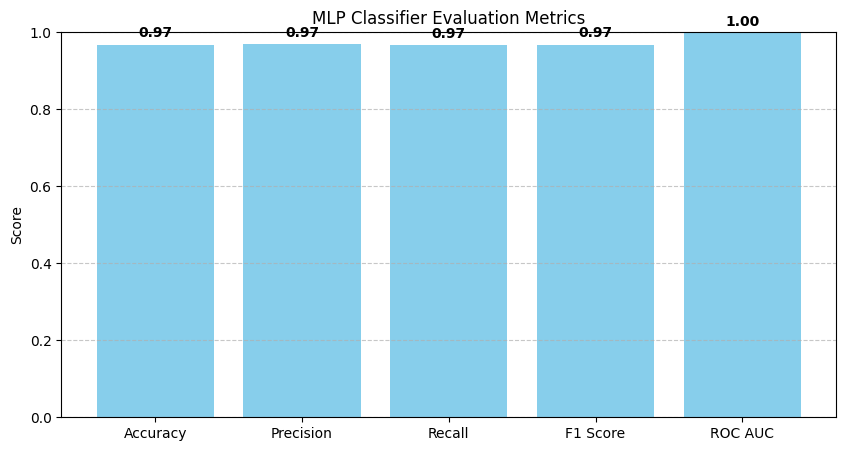

In [ ]:
# Store the results
mlp_original_metrics = {
    'Accuracy': accuracy_score(y_val, y_pred_mlp_original),
    'Precision': precision_score(y_val, y_pred_mlp_original, average='macro'),
    'Recall': recall_score(y_val, y_pred_mlp_original, average='macro'),
    'F1 Score': f1_score(y_val, y_pred_mlp_original, average='macro'),
    'ROC AUC': roc_auc_score(y_val, mlp_model_original.predict_proba(X_val), multi_class='ovr')
}

# --- Plotting the Evaluation Metrics ---
plt.figure(figsize=(10, 5))
plt.bar(mlp_original_metrics.keys(), mlp_original_metrics.values(), color='skyblue')
plt.ylim(0, 1)
plt.title('MLP Classifier Evaluation Metrics')
plt.ylabel('Score')
for i, v in enumerate(mlp_original_metrics.values()):
    plt.text(i, v + 0.02, f"{v:.2f}", ha='center', fontweight='bold')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

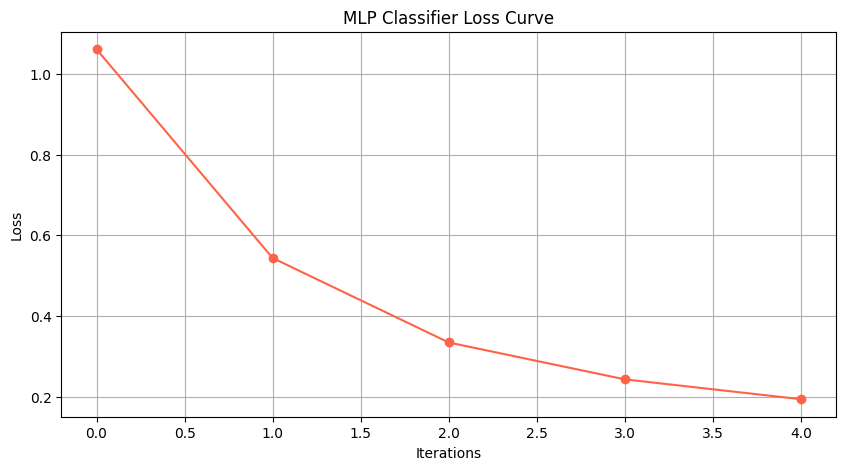

In [ ]:
# --- Plotting the Loss Curve ---
plt.figure(figsize=(10, 5))
plt.plot(mlp_model_original.loss_curve_, marker='o', color='tomato')
plt.title('MLP Classifier Loss Curve')
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.grid(True)
plt.show()

# **4. LSTM Implementation**

In [ ]:
# Convert target to categorical
y_train_cat = to_categorical(y_train)
y_val_cat = to_categorical(y_val)

# Build the model with two inputs
text_input = Input(shape=(maxlen,), name='text_input')
entity_input = Input(shape=(1,), name='entity_input')

embedding = Embedding(input_dim=len(tokenizer.word_index) + 1, output_dim=100)(text_input)
lstm = LSTM(100, dropout=0.2, recurrent_dropout=0.2)(embedding)

# Combine LSTM output with entity feature
combined = Concatenate()([lstm, entity_input])

output = Dense(4, activation='softmax')(combined)

lstm_model_original = Model(inputs=[text_input, entity_input], outputs=output)

lstm_model_original.compile(loss='categorical_crossentropy', optimizer=Adam(), metrics=['accuracy'])

lstm_model_original.summary()

# Train the model
history_original = lstm_model_original.fit(
    [X_train_pad, X_train_entity],
    y_train_cat,
    epochs=5,
    batch_size=64,
    validation_data=([X_val_pad, X_val_entity], y_val_cat),
    verbose=1
)

# Predict probabilities
y_pred_prob_lstm_original = lstm_model_original.predict([X_val_pad, X_val_entity])

# Convert probabilities to predicted class labels for classification metrics
y_pred_class_lstm_original = np.argmax(y_pred_prob_lstm_original, axis=1)

# Evaluation
print("LSTM Evaluation:")
print(classification_report(y_val, y_pred_class_lstm_original))
print(f"Accuracy: {accuracy_score(y_val, y_pred_class_lstm_original):.4f}")
print(f"Precision: {precision_score(y_val, y_pred_class_lstm_original, average='macro'):.4f}")
print(f"Recall: {recall_score(y_val, y_pred_class_lstm_original, average='macro'):.4f}")
print(f"F1 Score: {f1_score(y_val, y_pred_class_lstm_original, average='macro'):.4f}")

# Use predicted probabilities for ROC AUC
print(f"ROC AUC: {roc_auc_score(y_val, y_pred_prob_lstm_original, multi_class='ovr'):.4f}")

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ text_input          │ (None, 166)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding           │ (None, 166, 100)  │  4,074,800 │ text_input[0][0]  │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm (LSTM)         │ (None, 100)       │     80,400 │ embedding[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ entity_input        │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 101)       │          0 │ lstm[0][0],       │
│ (Concatenate)       │                   │            │ entity_input[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 4)         │        408 │ concatenate[0][0] │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 4,155,608 (15.85 MB)

 Trainable params: 4,155,608 (15.85 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/5
1120/1120 ━━━━━━━━━━━━━━━━━━━━ 559s 493ms/step - accuracy: 0.3043 - loss: 1.5511 - val_accuracy: 0.3003 - val_loss: 1.3779
Epoch 2/5
1120/1120 ━━━━━━━━━━━━━━━━━━━━ 554s 488ms/step - accuracy: 0.3046 - loss: 1.3662 - val_accuracy: 0.2933 - val_loss: 1.3762
Epoch 3/5
1120/1120 ━━━━━━━━━━━━━━━━━━━━ 595s 518ms/step - accuracy: 0.3128 - loss: 1.3654 - val_accuracy: 0.3093 - val_loss: 1.3681
Epoch 4/5
1120/1120 ━━━━━━━━━━━━━━━━━━━━ 585s 485ms/step - accuracy: 0.3125 - loss: 1.3660 - val_accuracy: 0.2853 - val_loss: 1.3663
Epoch 5/5
1120/1120 ━━━━━━━━━━━━━━━━━━━━ 566s 489ms/step - accuracy: 0.3167 - loss: 1.3654 - val_accuracy: 0.2843 - val_loss: 1.3703
32/32 ━━━━━━━━━━━━━━━━━━━━ 3s 92ms/step
LSTM Evaluation:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       171
           1       0.30      0.49      0.37       266
           2       0.00      0.00      0.00       285
           3       0.27      0.55      0.37       277

    ac

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/m

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


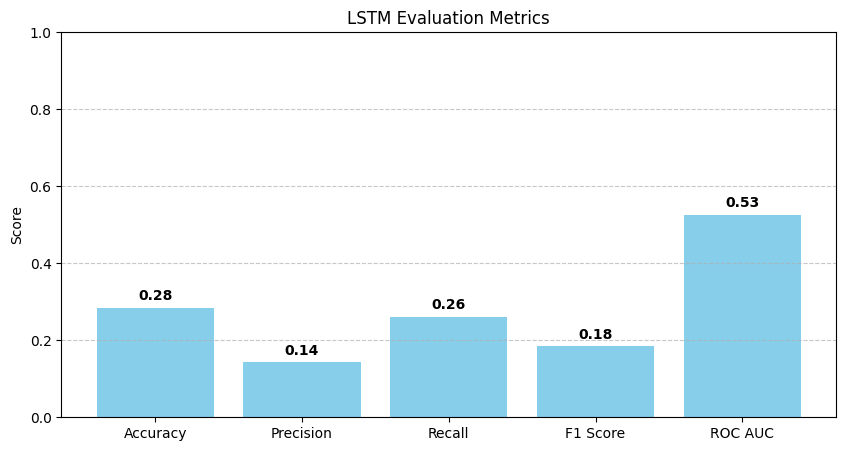

In [ ]:
# LSTM Metrics
lstm_original_metrics = {
    'Accuracy': accuracy_score(y_val, y_pred_class_lstm_original),
    'Precision': precision_score(y_val, y_pred_class_lstm_original, average='macro'),
    'Recall': recall_score(y_val, y_pred_class_lstm_original, average='macro'),
    'F1 Score': f1_score(y_val, y_pred_class_lstm_original, average='macro'),
    'ROC AUC': roc_auc_score(y_val, y_pred_prob_lstm_original, multi_class='ovr')
}

# --- Plotting only LSTM metrics ---
plt.figure(figsize=(10, 5))
plt.bar(lstm_original_metrics.keys(), lstm_original_metrics.values(), color='skyblue')
plt.ylim(0, 1)
plt.title('LSTM Evaluation Metrics')
plt.ylabel('Score')
for i, v in enumerate(lstm_original_metrics.values()):
    plt.text(i, v + 0.02, f"{v:.2f}", ha='center', fontweight='bold')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

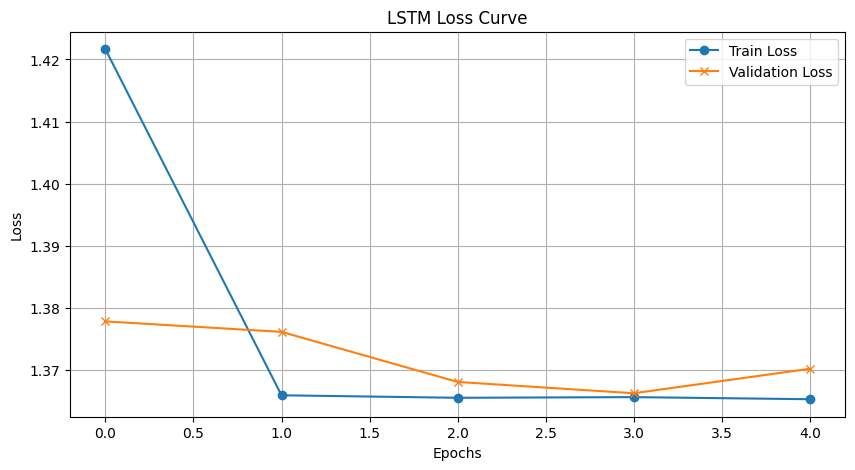

In [ ]:
# --- Plotting LSTM loss curve ---
plt.figure(figsize=(10, 5))
plt.plot(history_original.history['loss'], label='Train Loss', marker='o')
plt.plot(history_original.history['val_loss'], label='Validation Loss', marker='x')
plt.title('LSTM Loss Curve')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

# **5. Logistic Regression Implementation**

In [ ]:
# Initialize the Logistic Regression model
lr_model_original = LogisticRegression(random_state=42, max_iter=5, verbose=1)

# Train the model
lr_model_original.fit(X_train, y_train)

# Predict
y_pred_lr_original = lr_model_original.predict(X_val)

# Evaluation
print("Logistic Regression Evaluation:")
print(classification_report(y_val, y_pred_lr_original))
print(f"Accuracy: {accuracy_score(y_val, y_pred_lr_original):.4f}")
print(f"Precision: {precision_score(y_val, y_pred_lr_original, average='macro'):.4f}")
print(f"Recall: {recall_score(y_val, y_pred_lr_original, average='macro'):.4f}")
print(f"F1 Score: {f1_score(y_val, y_pred_lr_original, average='macro'):.4f}")
print(f"ROC AUC: {roc_auc_score(y_val, lr_model_original.predict_proba(X_val), multi_class='ovr'):.4f}")

Logistic Regression Evaluation:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       171
           1       0.27      0.98      0.42       266
           2       0.00      0.00      0.00       285
           3       0.21      0.03      0.05       277

    accuracy                           0.27       999
   macro avg       0.12      0.25      0.12       999
weighted avg       0.13      0.27      0.12       999

Accuracy: 0.2673
Precision: 0.1188
Recall: 0.2507
F1 Score: 0.1169
ROC AUC: 0.5126


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no pre

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


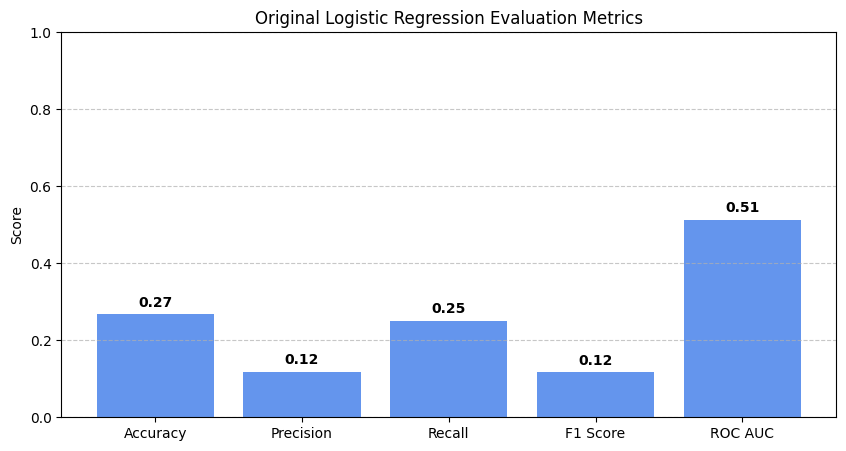

In [ ]:
# Logistic Regression Original metrics
lr_original_metrics = {
    'Accuracy': accuracy_score(y_val, y_pred_lr_original),
    'Precision': precision_score(y_val, y_pred_lr_original, average='macro'),
    'Recall': recall_score(y_val, y_pred_lr_original, average='macro'),
    'F1 Score': f1_score(y_val, y_pred_lr_original, average='macro'),
    'ROC AUC': roc_auc_score(y_val, lr_model_original.predict_proba(X_val), multi_class='ovr')
}

# --- Plotting only Original Logistic Regression metrics ---
plt.figure(figsize=(10, 5))
plt.bar(lr_original_metrics.keys(), lr_original_metrics.values(), color='cornflowerblue')
plt.ylim(0, 1)
plt.title('Original Logistic Regression Evaluation Metrics')
plt.ylabel('Score')
for i, v in enumerate(lr_original_metrics.values()):
    plt.text(i, v + 0.02, f"{v:.2f}", ha='center', fontweight='bold')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

# **6. Optimize MLP with Genetic Algorithm**

In [ ]:
# Genetic Algorithm setup
creator.create("FitnessMax", base.Fitness, weights=(1.0,))
creator.create("Individual", list, fitness=creator.FitnessMax)

toolbox = base.Toolbox()
toolbox.register("attr_float", np.random.rand)  # Random float [0,1]
toolbox.register("individual", tools.initRepeat, creator.Individual, toolbox.attr_float, 4)  # 4 hyperparameters
toolbox.register("population", tools.initRepeat, list, toolbox.individual)

# Evaluation function
def eval_mlp(individual):
    hidden_layer_sizes = int(individual[0] * 100) + 10
    alpha = individual[1] * 0.1
    learning_rate_init = individual[2] * 0.01

    model = MLPClassifier(
        hidden_layer_sizes=(hidden_layer_sizes,),
        alpha=alpha,
        learning_rate_init=learning_rate_init,
        max_iter=5,
        random_state=42,
        verbose=False
    )
    model.fit(X_train, y_train)
    y_pred = model.predict(X_val)

    accuracy = accuracy_score(y_val, y_pred)

    return (accuracy,)

toolbox.register("evaluate", eval_mlp)
toolbox.register("mate", tools.cxBlend, alpha=0.5)
toolbox.register("mutate", tools.mutPolynomialBounded, eta=0.5, low=0.0, up=1.0, indpb=0.2)
toolbox.register("select", tools.selTournament, tournsize=3)

# Parameters
population = toolbox.population(n=5)
NGEN = 1
hof = tools.HallOfFame(1)

algorithms.eaSimple(population, toolbox, cxpb=0.7, mutpb=0.2, ngen=NGEN, halloffame=hof, verbose=True)

# Best model
best_params = hof[0]
print("Best MLP params:", best_params)

hidden_layer_sizes = int(best_params[0] * 100) + 10
alpha = best_params[1] * 0.1
learning_rate_init = best_params[2] * 0.01

mlp_model_optimized = MLPClassifier(
    hidden_layer_sizes=(hidden_layer_sizes,),
    alpha=alpha,
    learning_rate_init=learning_rate_init,
    max_iter=5,
    random_state=42
)
mlp_model_optimized.fit(X_train, y_train)
y_pred_mlp_optimized = mlp_model_optimized.predict(X_val)

print("\nMLP Classification Report:\n")
print(classification_report(y_val, y_pred_mlp_optimized))

/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (5) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (5) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (5) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (5) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691

gen	nevals
0  	5     


/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (5) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (5) reached and the optimization hasn't converged yet.
  warnings.warn(


1  	2     
Best MLP params: [0.5466887833295248, 0.09706785534234041, 0.510645385551076, 0.05828986234137079]

MLP Classification Report:

              precision    recall  f1-score   support

           0       0.95      0.96      0.96       171
           1       0.97      0.97      0.97       266
           2       0.98      0.95      0.96       285
           3       0.95      0.98      0.96       277

    accuracy                           0.96       999
   macro avg       0.96      0.96      0.96       999
weighted avg       0.96      0.96      0.96       999



/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (5) reached and the optimization hasn't converged yet.
  warnings.warn(


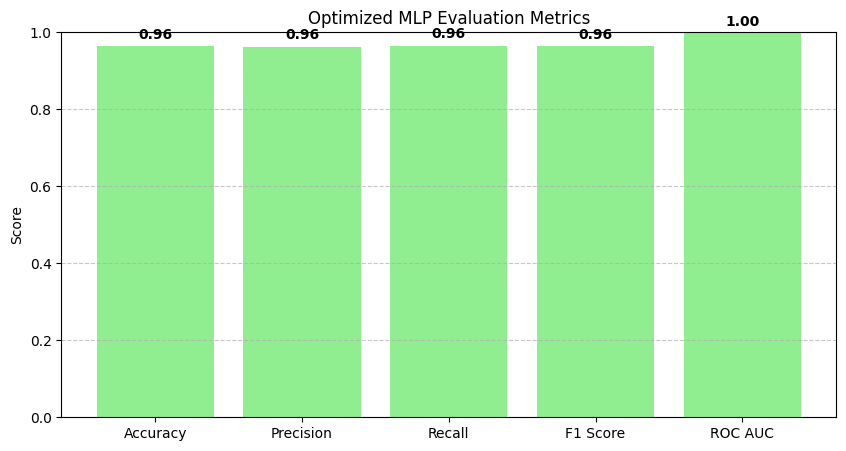

In [ ]:
# Optimized MLP Metrics
mlp_optimized_metrics = {
    'Accuracy': accuracy_score(y_val, y_pred_mlp_optimized),
    'Precision': precision_score(y_val, y_pred_mlp_optimized, average='macro'),
    'Recall': recall_score(y_val, y_pred_mlp_optimized, average='macro'),
    'F1 Score': f1_score(y_val, y_pred_mlp_optimized, average='macro'),
    'ROC AUC': roc_auc_score(y_val, mlp_model_optimized.predict_proba(X_val), multi_class='ovr')
}

# --- Plotting only optimized metrics ---
plt.figure(figsize=(10, 5))
plt.bar(mlp_optimized_metrics.keys(), mlp_optimized_metrics.values(), color='lightgreen')
plt.ylim(0, 1)
plt.title('Optimized MLP Evaluation Metrics')
plt.ylabel('Score')
for i, v in enumerate(mlp_optimized_metrics.values()):
    plt.text(i, v + 0.02, f"{v:.2f}", ha='center', fontweight='bold')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

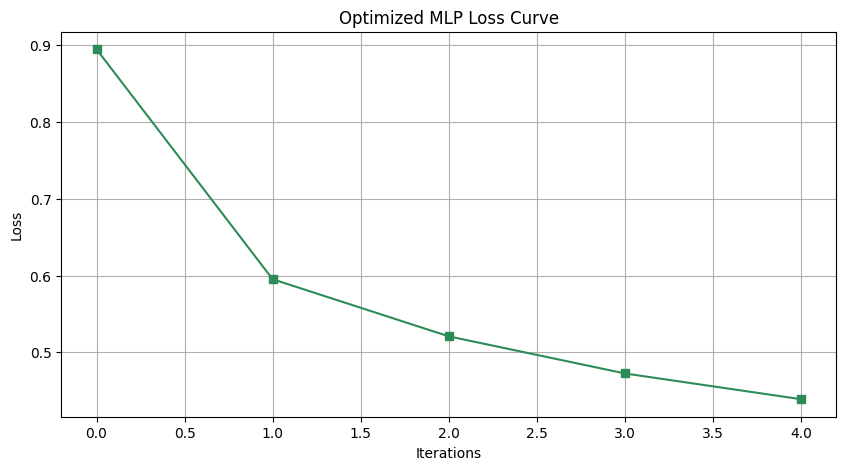

In [ ]:
# --- Plotting optimized loss curve ---
plt.figure(figsize=(10, 5))
plt.plot(mlp_model_optimized.loss_curve_, marker='s', color='seagreen')
plt.title('Optimized MLP Loss Curve')
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.grid(True)
plt.show()

# **7. Optimize LSTM with Genetic Algorithm**

In [ ]:
# Number of classes
n_classes = len(np.unique(y_train))

# Genetic Algorithm setup for LSTM
creator.create("FitnessMaxLSTM", base.Fitness, weights=(1.0,))
creator.create("IndividualLSTM", list, fitness=creator.FitnessMaxLSTM)

toolbox_lstm = base.Toolbox()
toolbox_lstm.register("attr_float", np.random.rand)
toolbox_lstm.register("individual", tools.initRepeat, creator.IndividualLSTM, toolbox_lstm.attr_float, 2)  # Only 2 hyperparameters now
toolbox_lstm.register("population", tools.initRepeat, list, toolbox_lstm.individual)

# Evaluation function
def eval_lstm(individual):
    lstm_units = int(individual[0] * 100) + 10
    learning_rate = individual[1] * 0.01
    fixed_epochs = 5  # Fixed to 5

    model = Sequential([
        Embedding(input_dim=5000, output_dim=64, input_length=X_train_pad.shape[1]),
        LSTM(lstm_units),
        Dense(n_classes, activation='softmax')
    ])
    model.compile(optimizer=Adam(learning_rate=learning_rate), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    model.fit(X_train_pad, y_train, epochs=fixed_epochs, batch_size=32, verbose=0)

    loss, accuracy = model.evaluate(X_val_pad, y_val, verbose=0)
    return (accuracy,)

toolbox_lstm.register("evaluate", eval_lstm)
toolbox_lstm.register("mate", tools.cxBlend, alpha=0.5)
toolbox_lstm.register("mutate", tools.mutPolynomialBounded, eta=0.5, low=0.0, up=1.0, indpb=0.2)
toolbox_lstm.register("select", tools.selTournament, tournsize=3)

# GA Parameters
population_lstm = toolbox_lstm.population(n=5)
NGEN = 1
hof_lstm = tools.HallOfFame(1)

# Run the Genetic Algorithm
algorithms.eaSimple(population_lstm, toolbox_lstm, cxpb=0.7, mutpb=0.2, ngen=NGEN, halloffame=hof_lstm, verbose=True)

# Best LSTM model
best_params_lstm = hof_lstm[0]
print("Best LSTM params:", best_params_lstm)

# Decode best params
lstm_units = int(best_params_lstm[0] * 100) + 10
learning_rate = best_params_lstm[1] * 0.01
fixed_epochs = 5

lstm_model_optimized_final = Sequential([
    Embedding(input_dim=5000, output_dim=64, input_length=X_train_pad.shape[1]),
    LSTM(lstm_units),
    Dense(n_classes, activation='softmax')
])
lstm_model_optimized_final.compile(optimizer=Adam(learning_rate=learning_rate), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train best model
history_final = lstm_model_optimized_final.fit(
    X_train_pad, y_train,
    epochs=fixed_epochs,
    batch_size=32,
    verbose=0,
    validation_data=(X_val_pad, y_val)  # << ADD THIS
)

# Predict probabilities
y_pred_prob_lstm_optimized = lstm_model_optimized_final.predict(X_val_pad)

# Convert probabilities to predicted class labels
y_pred_lstm_optimized = np.argmax(y_pred_prob_lstm_optimized, axis=1)

# Print the classification report
print("\nLSTM Classification Report:\n")
print(classification_report(y_val, y_pred_lstm_optimized))

# Print other evaluation metrics directly
print(f"Accuracy: {accuracy_score(y_val, y_pred_lstm_optimized):.4f}")
print(f"Precision (Macro): {precision_score(y_val, y_pred_lstm_optimized, average='macro'):.4f}")
print(f"Recall (Macro): {recall_score(y_val, y_pred_lstm_optimized, average='macro'):.4f}")
print(f"F1 Score (Macro): {f1_score(y_val, y_pred_lstm_optimized, average='macro'):.4f}")
print(f"ROC AUC: {roc_auc_score(y_val, y_pred_prob_lstm_optimized, multi_class='ovr'):.4f}")

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


gen	nevals
0  	5     
1  	1     
Best LSTM params: [0.4390204509807143, 0.7744759073203323]
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step

LSTM Classification Report:

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       171
           1       0.27      1.00      0.42       266
           2       0.00      0.00      0.00       285
           3       0.00      0.00      0.00       277

    accuracy                           0.27       999
   macro avg       0.07      0.25      0.11       999
weighted avg       0.07      0.27      0.11       999

Accuracy: 0.2663
Precision (Macro): 0.0666
Recall (Macro): 0.2500
F1 Score (Macro): 0.1051
ROC AUC: 0.5000


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/m

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


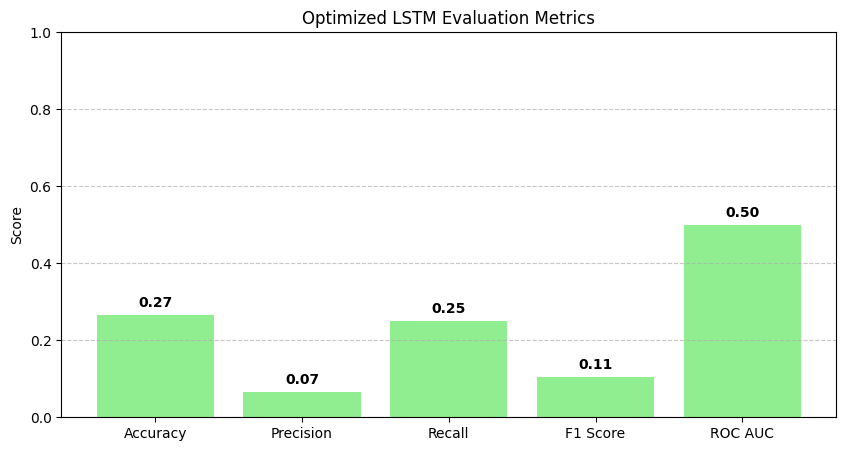

In [ ]:
# Optimized LSTM metrics
lstm_optimized_metrics = {
    'Accuracy': accuracy_score(y_val, y_pred_lstm_optimized),
    'Precision': precision_score(y_val, y_pred_lstm_optimized, average='macro'),
    'Recall': recall_score(y_val, y_pred_lstm_optimized, average='macro'),
    'F1 Score': f1_score(y_val, y_pred_lstm_optimized, average='macro'),
    'ROC AUC': roc_auc_score(to_categorical(y_val), y_pred_prob_lstm_optimized, multi_class='ovr')  # Use predicted probabilities for ROC AUC
}

# --- Plotting only Optimized LSTM metrics ---
plt.figure(figsize=(10, 5))
plt.bar(lstm_optimized_metrics.keys(), lstm_optimized_metrics.values(), color='lightgreen')
plt.ylim(0, 1)
plt.title('Optimized LSTM Evaluation Metrics')
plt.ylabel('Score')
for i, v in enumerate(lstm_optimized_metrics.values()):
    plt.text(i, v + 0.02, f"{v:.2f}", ha='center', fontweight='bold')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

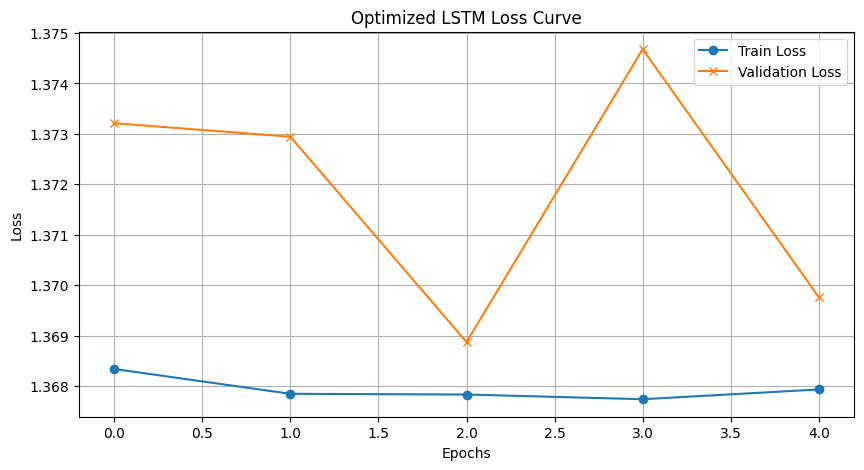

In [ ]:
# --- Plotting Optimized LSTM loss curve ---
plt.figure(figsize=(10, 5))
plt.plot(history_final.history['loss'], label='Train Loss', marker='o')
plt.plot(history_final.history['val_loss'], label='Validation Loss', marker='x')
plt.title('Optimized LSTM Loss Curve')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

# **8. Optimize LR with Genetic Algorithm**

In [ ]:
# Genetic Algorithm setup for Logistic Regression
creator.create("FitnessMaxLR", base.Fitness, weights=(1.0,))
creator.create("IndividualLR", list, fitness=creator.FitnessMaxLR)

toolbox_lr = base.Toolbox()
toolbox_lr.register("attr_float", np.random.rand)
toolbox_lr.register("individual", tools.initRepeat, creator.IndividualLR, toolbox_lr.attr_float, 2)  # 2 hyperparameters: C, penalty
toolbox_lr.register("population", tools.initRepeat, list, toolbox_lr.individual)

def eval_lr(individual):
    C = individual[0] * 10 + 0.1  # range ~ [0.1, 10.1]
    penalty = ['l1', 'l2'][int(round(individual[1]))]  # choose between l1 and l2

    model = LogisticRegression(C=C, penalty=penalty, solver='liblinear', random_state=42, max_iter=5)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_val)

    accuracy = accuracy_score(y_val, y_pred)
    precision = precision_score(y_val, y_pred, average='macro')
    recall = recall_score(y_val, y_pred, average='macro')
    f1 = f1_score(y_val, y_pred, average='macro')

    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")
    print(classification_report(y_val, y_pred))

    return (accuracy,)

toolbox_lr.register("evaluate", eval_lr)
toolbox_lr.register("mate", tools.cxBlend, alpha=0.5)
toolbox_lr.register("mutate", tools.mutPolynomialBounded, eta=0.5, low=0.0, up=1.0, indpb=0.2)
toolbox_lr.register("select", tools.selTournament, tournsize=3)

# Update population size to 5 and ngen to 1 for a single generation with 5 combinations
population_lr = toolbox_lr.population(n=5)  # Population size = 5
hof_lr = tools.HallOfFame(1)

algorithms.eaSimple(population_lr, toolbox_lr, cxpb=0.7, mutpb=0.2, ngen=1, halloffame=hof_lr, verbose=True)

# Best Logistic Regression model
best_params_lr = hof_lr[0]
print("Best Logistic Regression params:", best_params_lr)

C = best_params_lr[0] * 10 + 0.1
penalty = ['l1', 'l2'][int(round(best_params_lr[1]))]

lr_model_optimized = LogisticRegression(C=C, penalty=penalty, solver='liblinear', random_state=42, max_iter=5)
lr_model_optimized.fit(X_train, y_train)

# Predict
y_pred_lr_optimized = lr_model_optimized.predict(X_val)

# Evaluation
print("Optimized Logistic Regression Evaluation:")
print(classification_report(y_val, y_pred_lr_optimized))
print(f"Accuracy: {accuracy_score(y_val, y_pred_lr_optimized):.4f}")
print(f"Precision: {precision_score(y_val, y_pred_lr_optimized, average='macro'):.4f}")
print(f"Recall: {recall_score(y_val, y_pred_lr_optimized, average='macro'):.4f}")
print(f"F1 Score: {f1_score(y_val, y_pred_lr_optimized, average='macro'):.4f}")
print(f"ROC AUC: {roc_auc_score(y_val, lr_model_optimized.predict_proba(X_val), multi_class='ovr'):.4f}")

/usr/local/lib/python3.11/dist-packages/deap/creator.py:185: RuntimeWarning: A class named 'FitnessMaxLR' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
/usr/local/lib/python3.11/dist-packages/deap/creator.py:185: RuntimeWarning: A class named 'IndividualLR' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
/usr/local/lib/python3.11/dist-packages/sklearn/svm/_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Accuracy: 0.7197
Precision: 0.7289
Recall: 0.7098
F1 Score: 0.7114
              precision    recall  f1-score   support

           0       0.74      0.60      0.66       171
           1       0.67      0.83      0.74       266
           2       0.80      0.61      0.69       285
           3       0.71      0.81      0.75       277

    accuracy                           0.72       999
   macro avg       0.73      0.71      0.71       999
weighted avg       0.73      0.72      0.72       999



/usr/local/lib/python3.11/dist-packages/sklearn/svm/_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Accuracy: 0.9560
Precision: 0.9551
Recall: 0.9548
F1 Score: 0.9549
              precision    recall  f1-score   support

           0       0.95      0.94      0.94       171
           1       0.96      0.97      0.96       266
           2       0.97      0.95      0.96       285
           3       0.94      0.96      0.95       277

    accuracy                           0.96       999
   macro avg       0.96      0.95      0.95       999
weighted avg       0.96      0.96      0.96       999



/usr/local/lib/python3.11/dist-packages/sklearn/svm/_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Accuracy: 0.9590
Precision: 0.9595
Recall: 0.9586
F1 Score: 0.9590
              precision    recall  f1-score   support

           0       0.96      0.95      0.96       171
           1       0.95      0.97      0.96       266
           2       0.97      0.95      0.96       285
           3       0.95      0.96      0.95       277

    accuracy                           0.96       999
   macro avg       0.96      0.96      0.96       999
weighted avg       0.96      0.96      0.96       999



/usr/local/lib/python3.11/dist-packages/sklearn/svm/_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Accuracy: 0.9620
Precision: 0.9629
Recall: 0.9618
F1 Score: 0.9623
              precision    recall  f1-score   support

           0       0.97      0.96      0.96       171
           1       0.96      0.97      0.97       266
           2       0.97      0.95      0.96       285
           3       0.94      0.96      0.95       277

    accuracy                           0.96       999
   macro avg       0.96      0.96      0.96       999
weighted avg       0.96      0.96      0.96       999



/usr/local/lib/python3.11/dist-packages/sklearn/svm/_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Accuracy: 0.8979
Precision: 0.8987
Recall: 0.8972
F1 Score: 0.8971
              precision    recall  f1-score   support

           0       0.90      0.88      0.89       171
           1       0.86      0.93      0.90       266
           2       0.93      0.85      0.88       285
           3       0.90      0.93      0.92       277

    accuracy                           0.90       999
   macro avg       0.90      0.90      0.90       999
weighted avg       0.90      0.90      0.90       999

gen	nevals
0  	5     


/usr/local/lib/python3.11/dist-packages/sklearn/svm/_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Accuracy: 0.9620
Precision: 0.9617
Recall: 0.9618
F1 Score: 0.9617
              precision    recall  f1-score   support

           0       0.96      0.96      0.96       171
           1       0.96      0.97      0.97       266
           2       0.97      0.96      0.97       285
           3       0.95      0.96      0.96       277

    accuracy                           0.96       999
   macro avg       0.96      0.96      0.96       999
weighted avg       0.96      0.96      0.96       999



/usr/local/lib/python3.11/dist-packages/sklearn/svm/_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Accuracy: 0.9570
Precision: 0.9572
Recall: 0.9562
F1 Score: 0.9566
              precision    recall  f1-score   support

           0       0.96      0.95      0.95       171
           1       0.96      0.97      0.96       266
           2       0.97      0.95      0.96       285
           3       0.94      0.96      0.95       277

    accuracy                           0.96       999
   macro avg       0.96      0.96      0.96       999
weighted avg       0.96      0.96      0.96       999



/usr/local/lib/python3.11/dist-packages/sklearn/svm/_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Accuracy: 0.9600
Precision: 0.9604
Recall: 0.9595
F1 Score: 0.9599
              precision    recall  f1-score   support

           0       0.96      0.95      0.96       171
           1       0.96      0.97      0.96       266
           2       0.97      0.95      0.96       285
           3       0.95      0.96      0.95       277

    accuracy                           0.96       999
   macro avg       0.96      0.96      0.96       999
weighted avg       0.96      0.96      0.96       999



/usr/local/lib/python3.11/dist-packages/sklearn/svm/_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Accuracy: 0.9620
Precision: 0.9622
Recall: 0.9618
F1 Score: 0.9620
              precision    recall  f1-score   support

           0       0.96      0.96      0.96       171
           1       0.96      0.97      0.96       266
           2       0.97      0.96      0.97       285
           3       0.95      0.96      0.96       277

    accuracy                           0.96       999
   macro avg       0.96      0.96      0.96       999
weighted avg       0.96      0.96      0.96       999



/usr/local/lib/python3.11/dist-packages/sklearn/svm/_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Accuracy: 0.9620
Precision: 0.9629
Recall: 0.9618
F1 Score: 0.9623
              precision    recall  f1-score   support

           0       0.97      0.96      0.96       171
           1       0.96      0.97      0.97       266
           2       0.97      0.95      0.96       285
           3       0.94      0.96      0.95       277

    accuracy                           0.96       999
   macro avg       0.96      0.96      0.96       999
weighted avg       0.96      0.96      0.96       999

1  	5     
Best Logistic Regression params: [0.5643327795554854, 0.4746810744516665]
Optimized Logistic Regression Evaluation:
              precision    recall  f1-score   support

           0       0.97      0.96      0.96       171
           1       0.96      0.97      0.97       266
           2       0.97      0.95      0.96       285
           3       0.94      0.96      0.95       277

    accuracy                           0.96       999
   macro avg       0.96      0.96      0.96  

/usr/local/lib/python3.11/dist-packages/sklearn/svm/_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


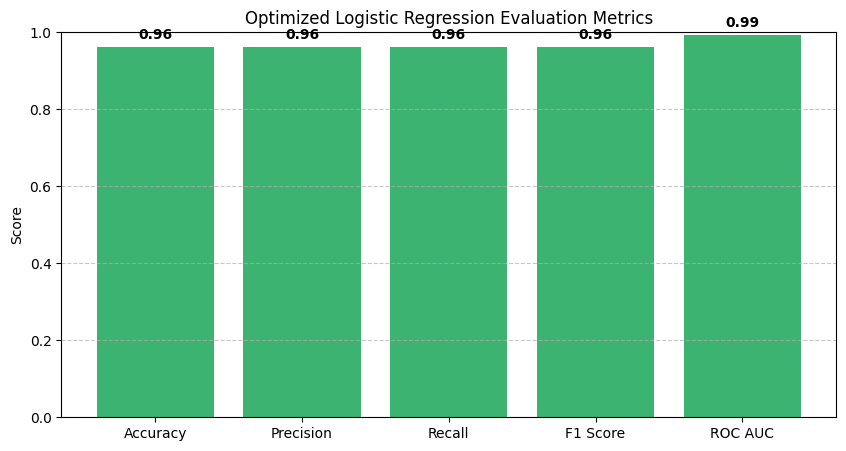

In [ ]:
# Optimized Logistic Regression metrics
lr_optimized_metrics = {
    'Accuracy': accuracy_score(y_val, y_pred_lr_optimized),
    'Precision': precision_score(y_val, y_pred_lr_optimized, average='macro'),
    'Recall': recall_score(y_val, y_pred_lr_optimized, average='macro'),
    'F1 Score': f1_score(y_val, y_pred_lr_optimized, average='macro'),
    'ROC AUC': roc_auc_score(y_val, lr_model_optimized.predict_proba(X_val), multi_class='ovr')
}

# --- Plotting only Optimized Logistic Regression metrics ---
plt.figure(figsize=(10, 5))
plt.bar(lr_optimized_metrics.keys(), lr_optimized_metrics.values(), color='mediumseagreen')
plt.ylim(0, 1)
plt.title('Optimized Logistic Regression Evaluation Metrics')
plt.ylabel('Score')
for i, v in enumerate(lr_optimized_metrics.values()):
    plt.text(i, v + 0.02, f"{v:.2f}", ha='center', fontweight='bold')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

# **9. Determining Which Model is Best Before and After Optimization**

In [ ]:
# Define model names
models = ['MLP (Orig)', 'MLP (Opt)', 'LSTM (Orig)', 'LSTM (Opt)', 'LogReg (Orig)', 'LogReg (Opt)']

# Calculate metric scores
metrics = {
    'Accuracy': [accuracy_score(y_val, y_pred) for y_pred in [
        y_pred_mlp_original, y_pred_mlp_optimized,
        y_pred_class_lstm_original, y_pred_lstm_optimized,
        y_pred_lr_original, y_pred_lr_optimized
    ]],
    'Precision': [precision_score(y_val, y_pred, average='macro') for y_pred in [
        y_pred_mlp_original, y_pred_mlp_optimized,
        y_pred_class_lstm_original, y_pred_lstm_optimized,
        y_pred_lr_original, y_pred_lr_optimized
    ]],
    'Recall': [recall_score(y_val, y_pred, average='macro') for y_pred in [
        y_pred_mlp_original, y_pred_mlp_optimized,
        y_pred_class_lstm_original, y_pred_lstm_optimized,
        y_pred_lr_original, y_pred_lr_optimized
    ]],
    'F1 Score': [f1_score(y_val, y_pred, average='macro') for y_pred in [
        y_pred_mlp_original, y_pred_mlp_optimized,
        y_pred_class_lstm_original, y_pred_lstm_optimized,
        y_pred_lr_original, y_pred_lr_optimized
    ]],
    'ROC AUC': [
        roc_auc_score(y_val, mlp_model_original.predict_proba(X_val), multi_class='ovr'),
        roc_auc_score(y_val, mlp_model_optimized.predict_proba(X_val), multi_class='ovr'),
        roc_auc_score(y_val, y_pred_prob_lstm_original, multi_class='ovr'),  # FIXED
        roc_auc_score(y_val, y_pred_prob_lstm_optimized, multi_class='ovr'),  # FIXED
        roc_auc_score(y_val, lr_model_original.predict_proba(X_val), multi_class='ovr'),
        roc_auc_score(y_val, lr_model_optimized.predict_proba(X_val), multi_class='ovr')
    ]
}

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


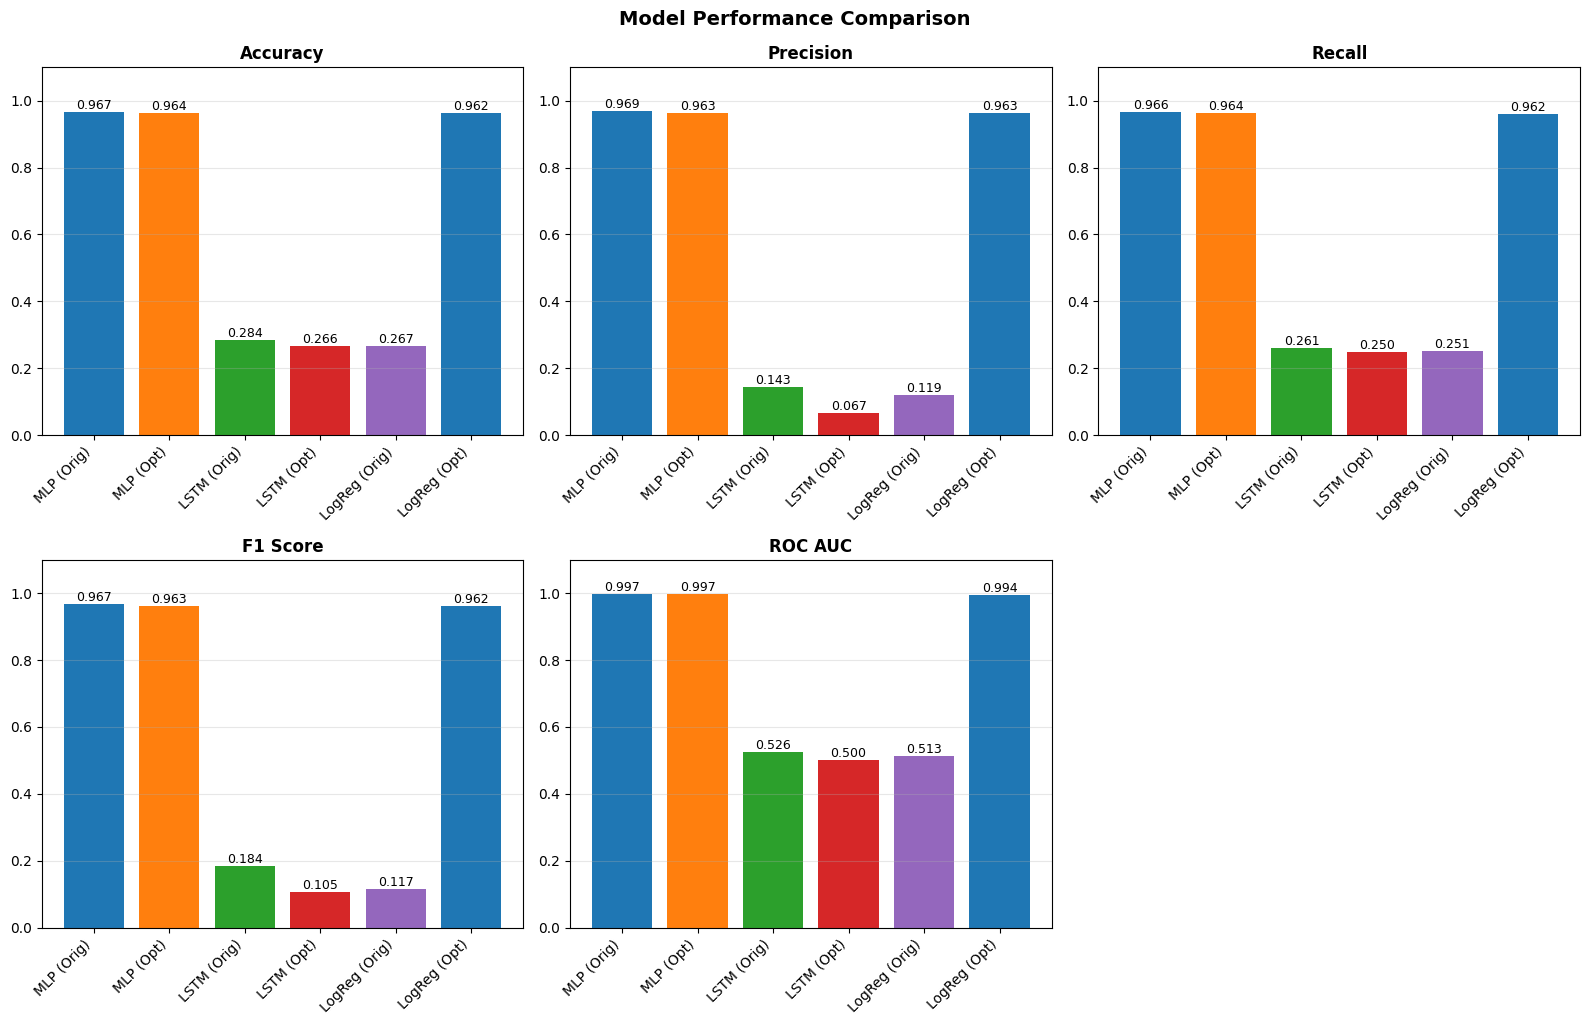

In [ ]:
# Create comparison plot with improved styling
plt.figure(figsize=(16, 10))
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd']

for i, (metric_name, scores) in enumerate(metrics.items()):
    plt.subplot(2, 3, i+1)
    bars = plt.bar(models, scores, color=colors)
    plt.title(metric_name, fontsize=12, fontweight='bold')
    plt.ylim(0, 1.1)
    plt.xticks(rotation=45, ha='right')
    plt.grid(axis='y', alpha=0.3)

    # Add value labels on top of bars
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height,
                 f'{height:.3f}',
                 ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.suptitle('Model Performance Comparison', y=1.02, fontsize=14, fontweight='bold')
plt.show()

In [ ]:
# Enhanced best model determination
print("\n=== Best Model Analysis ===")

# Original models comparison
orig_results = pd.DataFrame({
    'Model': ['MLP', 'LSTM', 'Logistic Regression'],
    'Accuracy': metrics['Accuracy'][::2],
    'F1 Score': metrics['F1 Score'][::2],
    'ROC AUC': metrics['ROC AUC'][::2]
})

print("\nOriginal Models Ranking:")
print(orig_results.sort_values('Accuracy', ascending=False).to_string(index=False))

# Optimized models comparison
opt_results = pd.DataFrame({
    'Model': ['MLP', 'LSTM', 'Logistic Regression'],
    'Accuracy': metrics['Accuracy'][1::2],
    'F1 Score': metrics['F1 Score'][1::2],
    'ROC AUC': metrics['ROC AUC'][1::2]
})

print("\nOptimized Models Ranking:")
print(opt_results.sort_values('Accuracy', ascending=False).to_string(index=False))

# Overall best model
all_models = ['MLP (Orig)', 'MLP (Opt)', 'LSTM (Orig)', 'LSTM (Opt)', 'LogReg (Orig)', 'LogReg (Opt)']
best_idx = np.argmax(metrics['Accuracy'])
print(f"\nOverall Best Model: {all_models[best_idx]} with accuracy: {metrics['Accuracy'][best_idx]:.4f}")


=== Best Model Analysis ===

Original Models Ranking:
              Model  Accuracy  F1 Score  ROC AUC
                MLP  0.966967  0.967403 0.996934
               LSTM  0.284284  0.184329 0.526357
Logistic Regression  0.267267  0.116859 0.512618

Optimized Models Ranking:
              Model  Accuracy  F1 Score  ROC AUC
                MLP  0.963964  0.963301 0.997058
Logistic Regression  0.961962  0.962277 0.993561
               LSTM  0.266266  0.105138 0.500000

Overall Best Model: MLP (Orig) with accuracy: 0.9670
